# Customer Segmentation Using RFM Analysis 

# **Author: Awais Manzoor**

## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Step 1: Load the Dataset  
- We load the Online Retail dataset directly from the Excel file.  
- This dataset contains transactions from a UK-based retailer between 2010–2011.  


In [4]:

# Load Excel file directly
df = pd.read_excel("Online Retail.xlsx")

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


# Step 2: Data Cleaning  
- We remove missing Customer IDs, filter out cancelled invoices,  
- and create a new column `TotalPrice = Quantity * UnitPrice`.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
 8   TotalPrice   397924 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


In [8]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
count,397924.00,397924,397924.00,397924.00,397924.00
mean,13.02,2011-07-10 23:43:36.912475648,3.12,15294.32,22.39
min,1.00,2010-12-01 08:26:00,0.00,12346.00,0.00
25%,2.00,2011-04-07 11:12:00,1.25,13969.00,4.68
50%,6.00,2011-07-31 14:39:00,1.95,15159.00,11.80
75%,12.00,2011-10-20 14:33:00,3.75,16795.00,19.80
max,80995.00,2011-12-09 12:50:00,8142.75,18287.00,168469.60
std,180.42,NaN,22.10,1713.17,309.06


In [ ]:
df = df.dropna(subset=["CustomerID"])
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# Calculate TotalPrice
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]



In [6]:
# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


# RFM Table  
- Compute Recency (days since last purchase), Frequency (unique invoices), and Monetary (total spend) for each customer.  


In [9]:
reference_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]


# RFM Scoring  
-  Assign scores (1–5) for Recency, Frequency, and Monetary, then combine them into RFM Segment and RFM Score.  


In [10]:
# Score each column: 1 (low) to 5 (high)
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Combine RFM Scores
rfm["RFM_Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm["RFM_Score"] = rfm[["R_Score", "F_Score", "M_Score"]].sum(axis=1)


# Segment Customers

In [11]:
def segment_customer(score):
    if score >= 9:
        return 'Champions'
    elif score >= 7:
        return 'Loyal'
    elif score >= 5:
        return 'Potential'
    else:
        return 'At Risk'

rfm["Segment"] = rfm["RFM_Score"].apply(segment_customer)


# Visualize RFM 
# Bar plot of customer segments


C:\Users\hp\AppData\Local\Temp\ipykernel_16092\3230745055.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


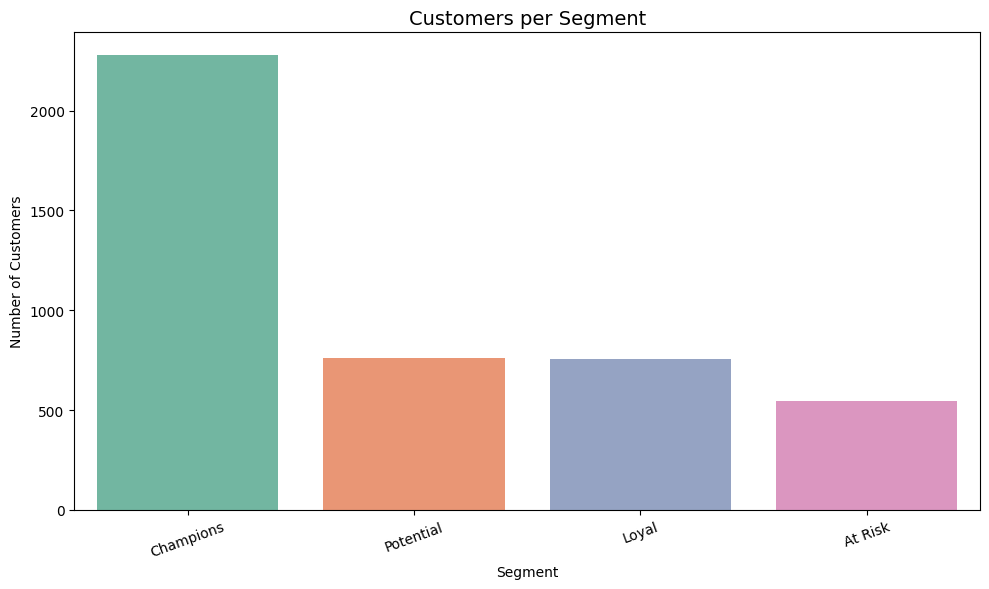

In [16]:
# 1) Bar chart — customers per segment
plt.figure(figsize=(10,6))
sns.countplot(
    data=rfm,
    x="Segment",
    order=rfm["Segment"].value_counts().index,
    palette="Set2"
)
plt.title("Customers per Segment", fontsize=14)
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


#  Heatmap — average R, F, M by segment


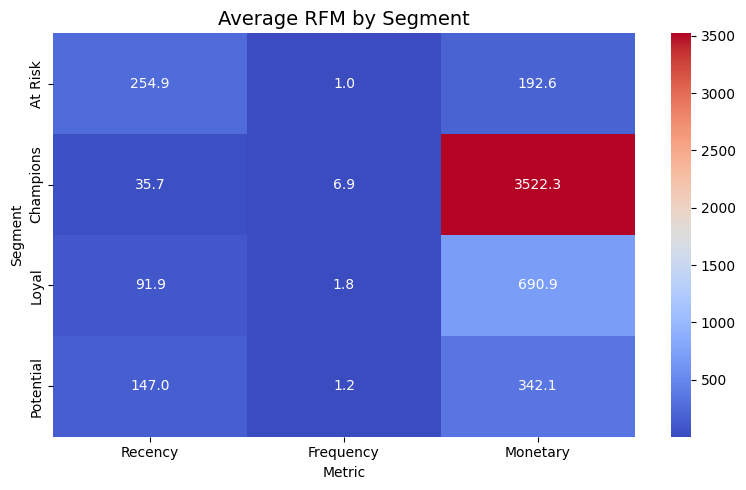

In [18]:
rfm_means = rfm.groupby("Segment")[["Recency","Frequency","Monetary"]].mean().round(1)

plt.figure(figsize=(8,5))
sns.heatmap(
    rfm_means,
    annot=True,
    fmt=".1f",
    cmap="coolwarm"
)
plt.title("Average RFM by Segment", fontsize=14)
plt.xlabel("Metric")
plt.ylabel("Segment")
plt.tight_layout()
plt.show()


#  Heatmap — Monetary by Recency × Frequency grid

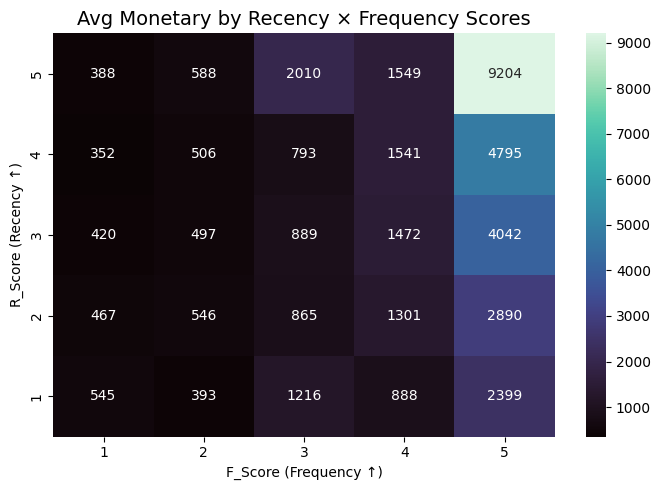

In [21]:
#  R_Score and F_Score (1–5). 
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)

rf_grid = (
    rfm
    .groupby(["R_Score","F_Score"])["Monetary"]
    .mean()
    .reset_index()
    .pivot(index="R_Score", columns="F_Score", values="Monetary")
    .sort_index(ascending=False)  # High R_Score (more recent) at top
)

plt.figure(figsize=(7,5))
sns.heatmap(
    rf_grid,
    annot=True,
    fmt=".0f",
    cmap="mako"
)
plt.title("Avg Monetary by Recency × Frequency Scores", fontsize=14)
plt.xlabel("F_Score (Frequency ↑)")
plt.ylabel("R_Score (Recency ↑)")
plt.tight_layout()
plt.show()


## Customer Segments and Marketing Approaches  

### Champions  
These are your most valuable customers. Keep them engaged with loyalty rewards, exclusive offers, and early access to new products.  

### Loyal Customers  
They already trust your brand. Strengthen the relationship with personalized recommendations and consistent communication.  

### Potential Loyalists  
This group shows promise. Convert them into long-term customers by offering special promotions, onboarding campaigns, and tailored deals.  

### At Risk  
These customers are slipping away. Win them back through re-engagement campaigns such as limited-time discounts, reminder emails, and personalized outreach.  
